## Conv2D

In [24]:
import autoreload
%reload_ext autoreload
%autoreload 2

In [25]:
# Check if GPU is available
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

In [26]:
import sys
import os
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
sys.path.append('../src')

import tensorflow as tf
from data_processing.mtb_data_provider import MtbDataProvider
from visualization.visualize import MtbVisualizer
from models.conv1d_model import Conv1dModel
from models.conv2d_model import Conv2dModel
from tensorflow.keras.callbacks import ModelCheckpoint

In [27]:
WINDOW_SIZE = 6000 # in milliseconds
KERNEL_LENGTH = 10 #in sample data points
KERNEL_HEIGHT = 2
FREQUENCY = 40 # in milliseconds
SAMPLE_SIZE = WINDOW_SIZE // FREQUENCY
print("SAMPLE_SIZE =", SAMPLE_SIZE)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.set_random_seed(RANDOM_SEED)

SAMPLE_SIZE = 150


### Prepare data

<img src="img/input_shape.png" alt="Drawing" style="width: 600px;"/>

#### Conv2d, multiple Sensors and multiple sessions

In [28]:
RAW_FILES = ['neureuth'] # Multiple Sessions ['neureuth', 'anothersession']
VAL_FILE = 'neureuth'

In [29]:
def load_data():
    X_result = None
    y_result = None
    for raw_file in RAW_FILES:
        X_tmp, y_tmp = MtbDataProvider.load_data('../data/raw/' + raw_file, '*?[0-9].csv', frequency=FREQUENCY)
        X_tmp = MtbDataProvider.sync_sensors(X_tmp)
        X_tmp, y_tmp = MtbDataProvider.slice_sensors(X_tmp, y_tmp, window_size=WINDOW_SIZE, frequency=FREQUENCY, step_size=.25)

        if X_result is None:
            X_result = X_tmp
            y_result = y_tmp
        else:
            X_result = np.concatenate((X_result, X_tmp))
            y_result = np.concatenate((y_result, y_tmp))

    return X_result, y_result
X, y = load_data()

reading  ../data/raw/neureuth_acc_2.csv
reading  ../data/raw/neureuth_acc_1.csv
reading  ../data/raw/neureuth_gyr_2.csv
reading  ../data/raw/neureuth_gyr_1.csv


In [30]:
# IF THERE IS NO VALIDATION SESSION (yet), split 80/20
# Do not run this multiple times in a row, because it overwrites X_train and therefore will get smaller and smaller

from sklearn.model_selection import train_test_split
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=.2, random_state=RANDOM_SEED, shuffle=True)

In [31]:
print(X_train.shape, y_train.shape)
print(X_dev.shape, y_dev.shape)

(772, 150, 4, 3) (772,)
(193, 150, 4, 3) (193,)


## Evaluation

### Conv2D, Multiple Sensors

In [32]:
model_cnn2 = Conv2dModel.build_model(input_shape=X_train[0].shape, 
                                     cnn_blocks=3,
                                     dropout=0.3,
                                     kernel_size=(KERNEL_LENGTH, KERNEL_HEIGHT))

In [33]:
model_cnn2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 4, 3)         183       
_________________________________________________________________
batch_normalization_v1_3 (Ba (None, 150, 4, 3)         12        
_________________________________________________________________
activation_3 (Activation)    (None, 150, 4, 3)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 150, 4, 8)         488       
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 150, 4, 8)         32        
_________________________________________________________________
activation_4 (Activation)    (None, 150, 4, 8)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 4, 8)          0         
__________

In [34]:
filepath="../checkpoints/conv2d-" + str(WINDOW_SIZE) + "-" + str(KERNEL_LENGTH) + "-{epoch:02d}-{val_sparse_categorical_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, save_best_only = True, monitor='val_sparse_categorical_accuracy', mode='max')
model_cnn2.fit(X_train, y_train,
              epochs=300,
              batch_size=16,
              validation_data=(X_dev, y_dev), 
              callbacks = [checkpoint])

Train on 772 samples, validate on 193 samples
Epoch 1/300
772/772 [==============================] - 1s 2ms/sample - loss: 2.4074 - sparse_categorical_accuracy: 0.5984 - val_loss: 0.9881 - val_sparse_categorical_accuracy: 0.7979
Epoch 2/300
772/772 [==============================] - 0s 592us/sample - loss: 2.1727 - sparse_categorical_accuracy: 0.7073 - val_loss: 0.9228 - val_sparse_categorical_accuracy: 0.7617
Epoch 3/300
772/772 [==============================] - 1s 655us/sample - loss: 1.7727 - sparse_categorical_accuracy: 0.7358 - val_loss: 0.7354 - val_sparse_categorical_accuracy: 0.8083
Epoch 4/300
772/772 [==============================] - 1s 666us/sample - loss: 1.6895 - sparse_categorical_accuracy: 0.7306 - val_loss: 0.6758 - val_sparse_categorical_accuracy: 0.8705
Epoch 5/300
772/772 [==============================] - 0s 615us/sample - loss: 1.4142 - sparse_categorical_accuracy: 0.7383 - val_loss: 0.7353 - val_sparse_categorical_accuracy: 0.8187
Epoch 6/300
772/772 [==========

Epoch 45/300
772/772 [==============================] - 0s 539us/sample - loss: 0.4907 - sparse_categorical_accuracy: 0.8601 - val_loss: 0.5318 - val_sparse_categorical_accuracy: 0.8756
Epoch 46/300
772/772 [==============================] - 0s 627us/sample - loss: 0.4862 - sparse_categorical_accuracy: 0.8420 - val_loss: 0.4933 - val_sparse_categorical_accuracy: 0.8860
Epoch 47/300
772/772 [==============================] - 0s 629us/sample - loss: 0.4945 - sparse_categorical_accuracy: 0.8523 - val_loss: 0.5521 - val_sparse_categorical_accuracy: 0.8601
Epoch 48/300
772/772 [==============================] - 0s 618us/sample - loss: 0.4919 - sparse_categorical_accuracy: 0.8510 - val_loss: 0.5257 - val_sparse_categorical_accuracy: 0.8549
Epoch 49/300
772/772 [==============================] - 1s 684us/sample - loss: 0.4818 - sparse_categorical_accuracy: 0.8614 - val_loss: 0.4979 - val_sparse_categorical_accuracy: 0.8964
Epoch 50/300
772/772 [==============================] - 0s 602us/sampl

772/772 [==============================] - 0s 590us/sample - loss: 0.3794 - sparse_categorical_accuracy: 0.8899 - val_loss: 0.5179 - val_sparse_categorical_accuracy: 0.8705
Epoch 90/300
772/772 [==============================] - 0s 605us/sample - loss: 0.3633 - sparse_categorical_accuracy: 0.8925 - val_loss: 0.4945 - val_sparse_categorical_accuracy: 0.8549
Epoch 91/300
772/772 [==============================] - 0s 627us/sample - loss: 0.3884 - sparse_categorical_accuracy: 0.8834 - val_loss: 0.4285 - val_sparse_categorical_accuracy: 0.8756
Epoch 92/300
772/772 [==============================] - 0s 565us/sample - loss: 0.3531 - sparse_categorical_accuracy: 0.8847 - val_loss: 0.4696 - val_sparse_categorical_accuracy: 0.8964
Epoch 93/300
772/772 [==============================] - 0s 604us/sample - loss: 0.3756 - sparse_categorical_accuracy: 0.8795 - val_loss: 0.4184 - val_sparse_categorical_accuracy: 0.9067
Epoch 94/300
772/772 [==============================] - 0s 599us/sample - loss: 0.4

Epoch 133/300
772/772 [==============================] - 0s 592us/sample - loss: 0.3106 - sparse_categorical_accuracy: 0.9197 - val_loss: 0.3683 - val_sparse_categorical_accuracy: 0.9067
Epoch 134/300
772/772 [==============================] - 0s 593us/sample - loss: 0.3193 - sparse_categorical_accuracy: 0.9003 - val_loss: 0.4206 - val_sparse_categorical_accuracy: 0.8912
Epoch 135/300
772/772 [==============================] - 0s 579us/sample - loss: 0.3340 - sparse_categorical_accuracy: 0.8964 - val_loss: 0.4043 - val_sparse_categorical_accuracy: 0.8756
Epoch 136/300
772/772 [==============================] - 0s 600us/sample - loss: 0.3193 - sparse_categorical_accuracy: 0.9054 - val_loss: 0.4018 - val_sparse_categorical_accuracy: 0.8912
Epoch 137/300
772/772 [==============================] - 0s 600us/sample - loss: 0.3482 - sparse_categorical_accuracy: 0.8912 - val_loss: 0.3607 - val_sparse_categorical_accuracy: 0.9223
Epoch 138/300
772/772 [==============================] - 0s 610us

Epoch 177/300
772/772 [==============================] - 0s 612us/sample - loss: 0.3387 - sparse_categorical_accuracy: 0.9080 - val_loss: 0.4603 - val_sparse_categorical_accuracy: 0.8601
Epoch 178/300
772/772 [==============================] - 0s 610us/sample - loss: 0.2936 - sparse_categorical_accuracy: 0.9158 - val_loss: 0.4264 - val_sparse_categorical_accuracy: 0.8808
Epoch 179/300
772/772 [==============================] - 0s 619us/sample - loss: 0.3064 - sparse_categorical_accuracy: 0.9171 - val_loss: 0.3752 - val_sparse_categorical_accuracy: 0.9171
Epoch 180/300
772/772 [==============================] - 0s 598us/sample - loss: 0.3110 - sparse_categorical_accuracy: 0.9119 - val_loss: 0.3521 - val_sparse_categorical_accuracy: 0.9119
Epoch 181/300
772/772 [==============================] - 0s 592us/sample - loss: 0.3154 - sparse_categorical_accuracy: 0.9197 - val_loss: 0.3896 - val_sparse_categorical_accuracy: 0.8912
Epoch 182/300
772/772 [==============================] - 0s 608us

Epoch 221/300
772/772 [==============================] - 0s 622us/sample - loss: 0.2850 - sparse_categorical_accuracy: 0.9262 - val_loss: 0.3887 - val_sparse_categorical_accuracy: 0.8860
Epoch 222/300
772/772 [==============================] - 0s 597us/sample - loss: 0.2538 - sparse_categorical_accuracy: 0.9365 - val_loss: 0.3696 - val_sparse_categorical_accuracy: 0.9119
Epoch 223/300
772/772 [==============================] - 0s 571us/sample - loss: 0.2785 - sparse_categorical_accuracy: 0.9236 - val_loss: 0.3821 - val_sparse_categorical_accuracy: 0.8860
Epoch 224/300
772/772 [==============================] - 0s 609us/sample - loss: 0.2803 - sparse_categorical_accuracy: 0.9313 - val_loss: 0.3685 - val_sparse_categorical_accuracy: 0.9067
Epoch 225/300
772/772 [==============================] - 0s 600us/sample - loss: 0.2869 - sparse_categorical_accuracy: 0.9262 - val_loss: 0.3876 - val_sparse_categorical_accuracy: 0.9067
Epoch 226/300
772/772 [==============================] - 0s 585us

Epoch 265/300
772/772 [==============================] - 0s 602us/sample - loss: 0.3121 - sparse_categorical_accuracy: 0.9210 - val_loss: 0.4278 - val_sparse_categorical_accuracy: 0.8497
Epoch 266/300
772/772 [==============================] - 0s 625us/sample - loss: 0.2852 - sparse_categorical_accuracy: 0.9184 - val_loss: 0.3407 - val_sparse_categorical_accuracy: 0.9119
Epoch 267/300
772/772 [==============================] - 0s 612us/sample - loss: 0.2734 - sparse_categorical_accuracy: 0.9326 - val_loss: 0.3365 - val_sparse_categorical_accuracy: 0.9171
Epoch 268/300
772/772 [==============================] - 0s 586us/sample - loss: 0.2391 - sparse_categorical_accuracy: 0.9391 - val_loss: 0.4902 - val_sparse_categorical_accuracy: 0.8653
Epoch 269/300
772/772 [==============================] - 0s 599us/sample - loss: 0.2531 - sparse_categorical_accuracy: 0.9313 - val_loss: 0.4340 - val_sparse_categorical_accuracy: 0.8808
Epoch 270/300
772/772 [==============================] - 0s 593us

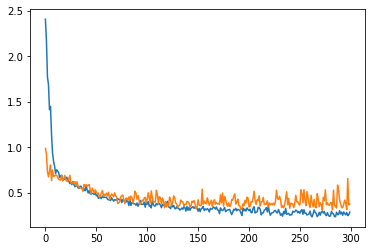

In [36]:
plt.plot(model_cnn2.history.history['loss'])
plt.plot(model_cnn2.history.history['val_loss'])
plt.show()

## Evaluation

* 0 = blue = easy
* 1 = red = medium
* 2 = black = hard
* 3 = white = not riding

### Predicted results

In [37]:
y_pred_dev = model_cnn2.predict(X_dev)
y_pred_dev = np.argmax(y_pred_dev, axis=1)

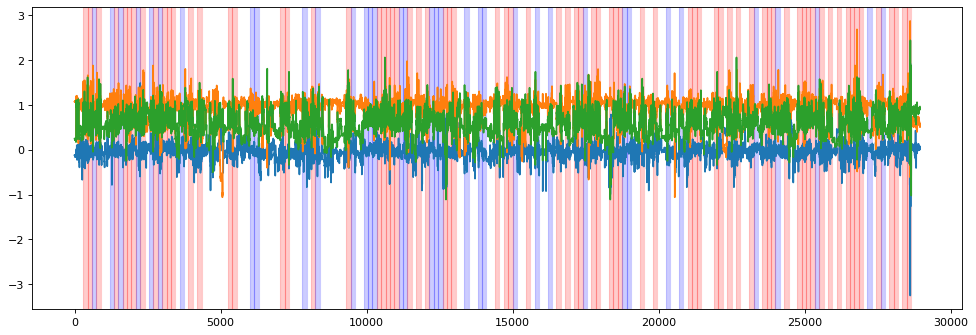

In [38]:
# This only plots the first sensor
X_dev_plot = X_dev if len(X_dev.shape) <= 3 else X_dev[:,:,0]
MtbVisualizer.plot_results(X_dev_plot, y_pred_dev, SAMPLE_SIZE)

### True results

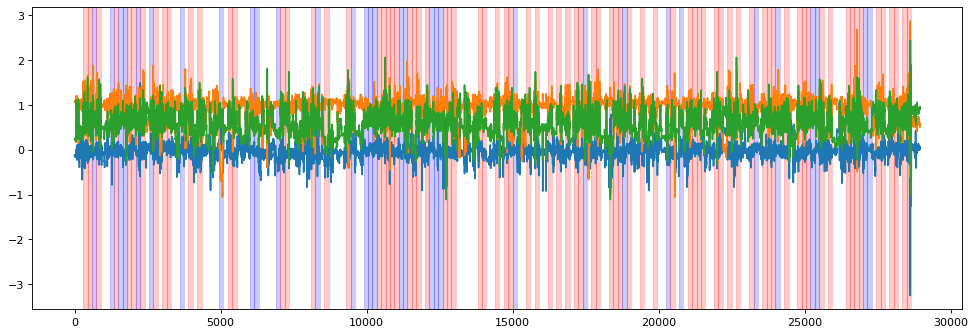

In [39]:
MtbVisualizer.plot_results(X_dev_plot, y_dev, SAMPLE_SIZE)

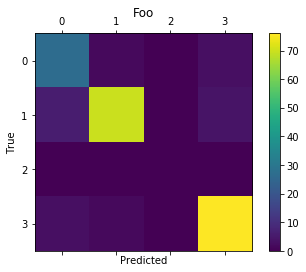

In [43]:
MtbVisualizer.print_confusion_matrix(y_dev, y_pred_dev, labels=[0,1,2,3])

### Test on Train data

In [41]:
y_pred = model_cnn2.predict(X)
y_pred = np.argmax(y_pred, axis=1)

### Predicted results

PREDICTED


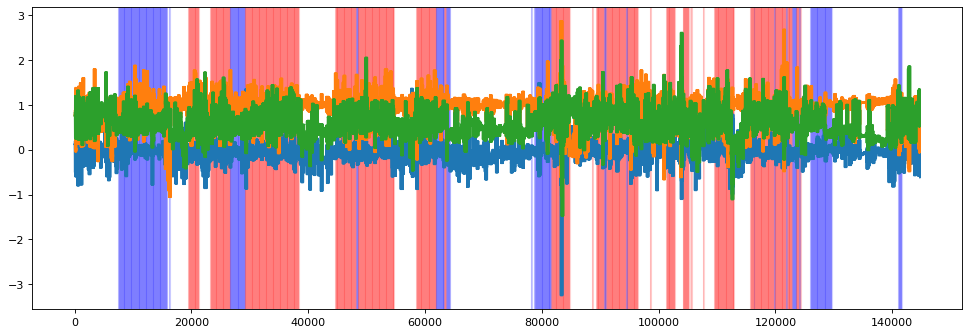

In [45]:
X_plot = X[:,:,0]
MtbVisualizer.plot_results(X_plot, y_pred, SAMPLE_SIZE)

### True results

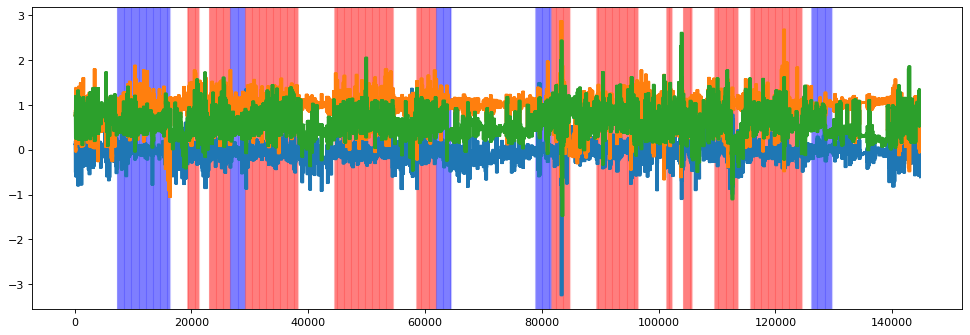

In [47]:
X_plot = X[:,:,0]
MtbVisualizer.plot_results(X_plot, y, SAMPLE_SIZE)

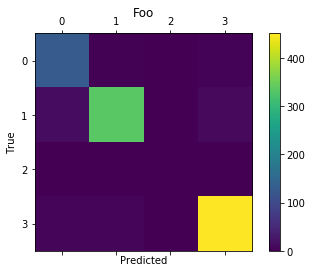

In [48]:
MtbVisualizer.print_confusion_matrix(y, y_pred, labels=[0,1,2,3])

## Explore per sensor

ACTUAL, per sensor


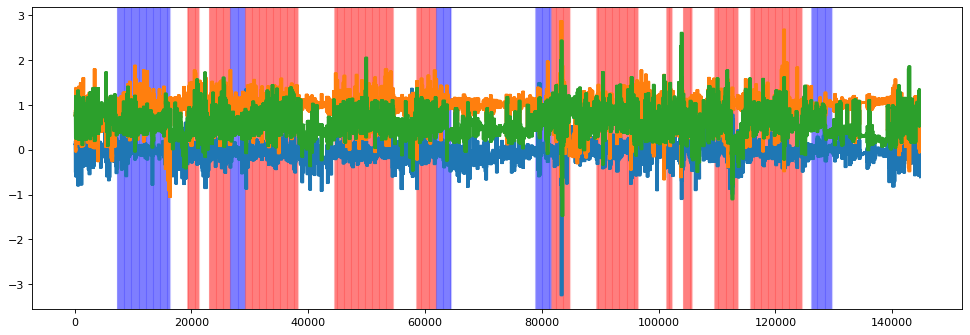

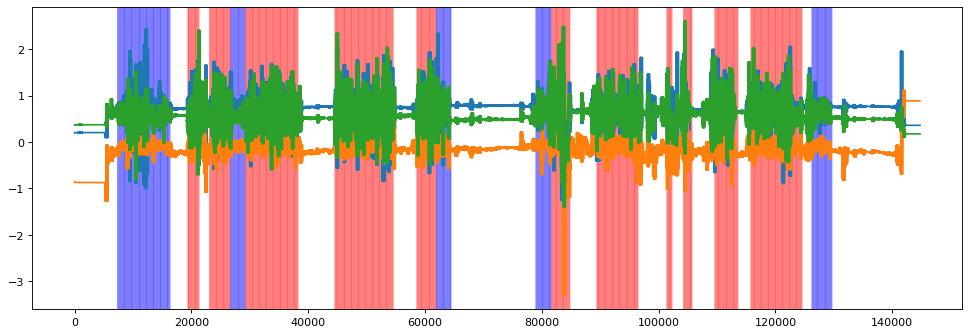

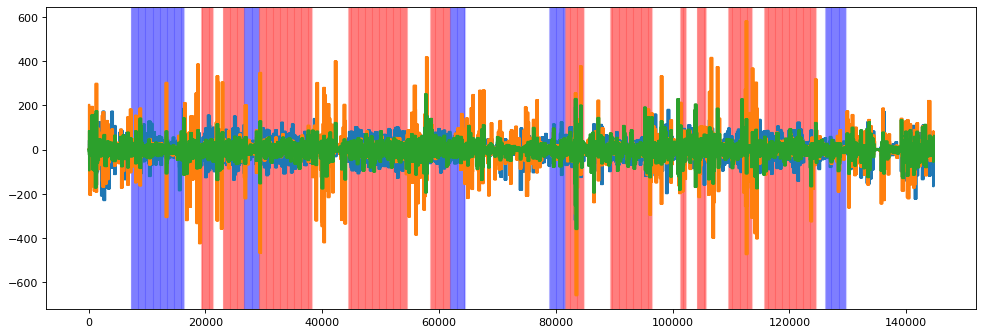

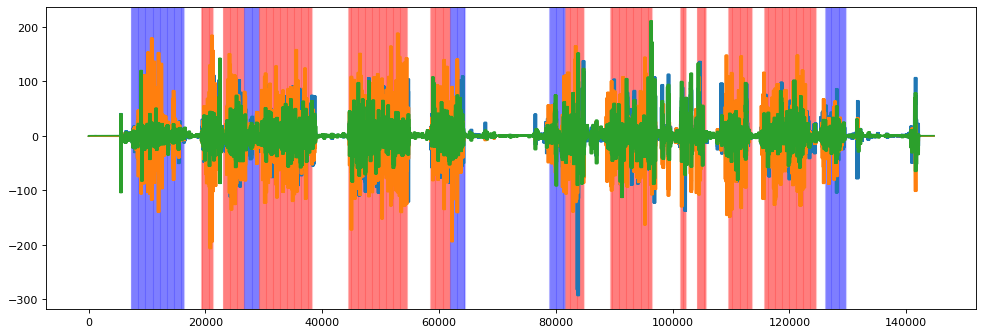

In [46]:
for i in range(0, X_train.shape[2]):
    X_plot = X_train if len(X.shape) <= 3 else X[:,:,i]
    MtbVisualizer.plot_results(X_plot, y, SAMPLE_SIZE)#[205:220]